In [1]:
import pandas as pd
import os
from datetime import datetime as dt

from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt

import pycountry as pc

import warnings
warnings.filterwarnings('ignore')

## Import predictions and join with true values

In [2]:
target_clsf = 'armedconf'
target_regr = 'deaths_all_pc'

unit_of_analyis = 'isocode'

# decide on period to predict for
start_month_year = dt(2018, 1, 1)
end_month_year = dt(2021,12,1)#(2018, 12, 1)

In [3]:
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

In [4]:
df_og = pd.read_csv(os.path.abspath(parent_path + '/data/preprocessed_df.csv'))

df_og['month_year'] = pd.to_datetime(df_og['month_year'])
print(df_og.date.min(), df_og.date.max())


1989-01-01 2023-05-01


In [8]:
def make_target(df: pd.DataFrame, shifter: int, target: str): # t is the number of periods for the shift

    # loop through each period and generate the shift variables
    for i in range(1, shifter+1):
        col_name = f'{target}{i}' # name doesn't matter, just interimset str(target) + f'{i}' # 

        df[col_name] = df.groupby(unit_of_analyis)[str(target)].shift(-i)

    # take the maximum for t periods forward and create the new variable
    df['target_clsf_f{}'.format(shifter)] = df[[f'{target}{i}' for i in range(1, shifter+1)]].max(axis=1, skipna=False)

    # drop the shift variables
    df = df.drop(columns=[f'{target}{i}' for i in range(1, shifter+1)])
    
    return(df)

In [21]:
print('armed conflicts:', df_og.armedconf.sum())
print('perc of observ.:', df_og.armedconf.sum()/len(df_og)*100)

armed conflicts: 7144
perc of observ.: 8.94397496087637


### Classifier

In [143]:
# load all predictions and combined them into one dataframe and join with og_vals
pred_f1_clsf = pd.read_csv(os.path.abspath(parent_path + f'/EDA_files/predictions_clsf_f1_d8_{target_clsf}.csv'))
pred_f1_clsf.drop('Unnamed: 0', axis=1, inplace=True)
pred_f2_clsf = pd.read_csv(os.path.abspath(parent_path + f'/EDA_files/predictions_clsf_f2_d8_{target_clsf}.csv'))
pred_f2_clsf.drop('Unnamed: 0', axis=1, inplace=True)
print(pred_f1_clsf.shape, pred_f2_clsf.shape)

pred_vals_clsf = pd.merge(pred_f1_clsf, pred_f2_clsf, on=[unit_of_analyis, 'month_year'], how='outer')

#pred_vals_clsf = pred_f1_clsf

(9360, 5) (9360, 5)


In [10]:
og_vals_clsf = df_og.copy()

cols_to_keep = ['month_year', unit_of_analyis, target_clsf] 
og_vals_clsf = og_vals_clsf[cols_to_keep]


fwds = [1,2]
for fwd in fwds:
        og_vals_clsf = make_target(og_vals_clsf, fwd, target_clsf)
       
# drop training data values & months not inlcuded in prediction range
og_vals_clsf = og_vals_clsf[og_vals_clsf['month_year'] >= start_month_year]
og_vals_clsf = og_vals_clsf[og_vals_clsf['month_year'] <= end_month_year]

#print(og_vals_clsf.shape, pred_vals_clsf.shape)


In [145]:
# Merge originals (target) and predictions
pred_vals_clsf['month_year'] = pred_vals_clsf['month_year'].astype('datetime64[D]')
og_vals_clsf['month_year'] = og_vals_clsf['month_year'].astype('datetime64[D]')

pred_all_clsf = pd.merge(og_vals_clsf, pred_vals_clsf, on=['month_year', unit_of_analyis], how='outer')

### XGBoost Classifier

In [15]:
# load all predictions and combined them into one dataframe and join with og_vals
pred_f1_xgb = pd.read_csv(os.path.abspath(parent_path + f'/2. Models and Metrics/predictions_xgb_f1_d8_{target_clsf}.csv'))
pred_f1_xgb.drop('Unnamed: 0', axis=1, inplace=True)
pred_f2_xgb = pd.read_csv(os.path.abspath(parent_path + f'/2. Models and Metrics/predictions_xgb_f2_d8_{target_clsf}.csv'))
pred_f2_xgb.drop('Unnamed: 0', axis=1, inplace=True)
print(pred_f1_xgb.shape, pred_f2_xgb.shape)

pred_vals_xbg = pd.merge(pred_f1_xgb, pred_f2_xgb, on=[unit_of_analyis, 'month_year'], how='outer')

#pred_vals_clsf = pred_f1_clsf

# use same original valze as for classification
print(og_vals_clsf.shape, pred_vals_xbg.shape)

# Merge originals (target) and predictions
pred_vals_xbg['month_year'] = pred_vals_xbg['month_year'].astype('datetime64[D]')
og_vals_clsf['month_year'] = og_vals_clsf['month_year'].astype('datetime64[D]')

pred_all_xgb = pd.merge(og_vals_clsf, pred_vals_xbg, on=['month_year', unit_of_analyis], how='outer')

(9360, 5) (9360, 5)
(9360, 5) (9360, 8)


### Regressor

In [122]:
# load all predictions and combined them into one dataframe
#pred_f1 = pd.read_csv(os.path.abspath(path + '/preds/2018only_regr_since2000/predictions_f1_d8_conflict.csv'))
#pred_f1 = pd.read_csv(os.path.abspath(path + '/predictions_f1_d8_deaths_pc.csv'))

pred_f1_regr = pd.read_csv(os.path.abspath(parent_path + f'/EDA_files/predictions_regr_f1_d8_{target_regr}.csv'))
pred_f1_regr.drop('Unnamed: 0', axis=1, inplace=True)

pred_f2_regr = pd.read_csv(os.path.abspath(parent_path + f'/EDA_files/predictions_regr_f2_d8_{target_regr}.csv'))
pred_f2_regr.drop('Unnamed: 0', axis=1, inplace=True)
print(pred_f1_regr.shape, pred_f2_regr.shape)

pred_vals_regr = pd.merge(pred_f1_regr, pred_f2_regr, on=[unit_of_analyis, 'month_year'], how='outer')
#pred_vals_regr = pred_f1_regr


(9360, 5) (9360, 5)


In [123]:
og_vals_regr = df_og.copy()

cols_to_keep = ['month_year', unit_of_analyis, target_regr] 
og_vals_regr = og_vals_regr[cols_to_keep]


fwds = [1,2]
for fwd in fwds:
        #og_vals = make_target(og_vals, fwd, target_clsf)
        og_vals_regr[f'target_regr_f{fwd}'] = og_vals_regr.groupby(unit_of_analyis)[target_regr].shift(-fwd)

# drop training data values & months not inlcuded in prediction range
og_vals_regr = og_vals_regr[og_vals_regr['month_year'] >= start_month_year]
og_vals_regr = og_vals_regr[og_vals_regr['month_year'] <= end_month_year]

print(og_vals_regr.shape, pred_vals_regr.shape)


(9360, 5) (9360, 8)


In [124]:
# Merge originals (target) and predictions
pred_vals_regr['month_year'] = pred_vals_regr['month_year'].astype('datetime64[D]')
og_vals_regr['month_year'] = og_vals_regr['month_year'].astype('datetime64[D]')


pred_all_regr = pd.merge(og_vals_regr, pred_vals_regr, on=['month_year', unit_of_analyis], how='outer')
pred_all_regr

,month_year,isocode,deaths_all_pc,target_regr_f1,target_regr_f2,pred_deaths_all_pc_f1_all,pred_deaths_all_pc_f1_hs,pred_deaths_all_pc_f1_tx,pred_deaths_all_pc_f2_all,pred_deaths_all_pc_f2_hs,pred_deaths_all_pc_f2_tx
0,2018-01-01,AFG,4.838255,4.064134,3.933297,10.769095,10.802527,1.698081,12.223327,12.444894,2.138721
1,2018-01-01,AGO,0.000000,0.000000,0.003198,0.011381,0.014892,0.026625,0.023153,0.031046,0.015200
2,2018-01-01,ALB,0.000000,0.000000,0.000000,0.000732,0.000597,0.017914,0.001461,0.001081,0.021282
3,2018-01-01,ARE,0.000000,0.000000,0.000000,0.000749,0.000606,0.026338,0.001485,0.001035,0.014456
4,2018-01-01,ARG,0.000000,0.000000,0.000000,0.000728,0.000570,0.007453,0.001461,0.000958,0.011010
...,...,...,...,...,...,...,...,...,...,...,...
9355,2021-12-01,XKX,0.000000,0.000000,0.000000,0.000660,0.000490,0.008268,0.001522,0.000713,0.033445
9356,2021-12-01,YEM,3.887011,0.521502,1.491739,6.112846,6.218450,0.735913,8.945432,9.220033,1.660586
9357,2021-12-01,ZAF,0.000000,0.001684,0.001684,0.014548,0.044101,0.019057,0.086987,0.121115,0.033937
9358,2021-12-01,ZMB,0.000000,0.000000,0.000000,0.000660,0.000496,0.020645,0.001230,0.000734,0.028372


## Metrics

In [17]:
# Allows us to obtain the predictions for a given target and original shifted data

def get_tar_pred(df: pd.DataFrame() , fwd: int, model: str, start_time: dt, target: str, type: str):
    
    target_col = f'target_{type}_f{fwd}'
    pred_col = f'pred_{target}_f{fwd}_{model}'

    df = df[[unit_of_analyis, 'month_year', target_col, pred_col]] 
    #df['month_year'] = pd.to_datetime(df['date_str'])
    df = df[df.month_year >= start_time]
    df = df.dropna()

    y_preds = df[pred_col]
    y_trues = df[target_col]

    return y_trues, y_preds

### Metrics for tree-based classifier

In [152]:
pred_all_clsf['pred_armedconf_f1_zero'] = 0 
pred_all_clsf

,month_year,isocode,armedconf,target_clsf_f1,target_clsf_f2,pred_armedconf_f1_all,pred_armedconf_f1_hs,pred_armedconf_f1_tx,pred_armedconf_f2_all,pred_armedconf_f2_hs,pred_armedconf_f2_tx,pred_armedconf_f1_zero
0,2018-01-01,AFG,True,1.0,1.0,0.997375,0.994650,0.988983,0.997646,0.996855,0.988007,0
1,2018-01-01,AGO,False,0.0,0.0,0.174235,0.249577,0.455992,0.276973,0.367871,0.534406,0
2,2018-01-01,ALB,False,0.0,0.0,0.003833,0.009131,0.012218,0.007378,0.015465,0.021045,0
3,2018-01-01,ARE,False,0.0,0.0,0.005291,0.026137,0.001856,0.005994,0.043480,0.001883,0
4,2018-01-01,ARG,False,0.0,0.0,0.005054,0.008747,0.009809,0.005494,0.014932,0.008500,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9355,2021-12-01,XKX,False,0.0,0.0,0.003933,0.006540,0.030147,0.007127,0.011758,0.021951,0
9356,2021-12-01,YEM,True,1.0,1.0,0.996583,0.997203,0.972011,0.997539,0.997730,0.971987,0
9357,2021-12-01,ZAF,False,0.0,0.0,0.258487,0.241518,0.236340,0.340253,0.377366,0.266508,0
9358,2021-12-01,ZMB,False,0.0,0.0,0.004172,0.006964,0.014222,0.006104,0.012916,0.015634,0


In [14]:
def get_roc_pr(df_og: pd.DataFrame, fwd: int, target: str, models: list, staryearid, binary=True, plot=True):
    """Function to return the roc and pr values for a given target, level and forward period"""
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    for model in models:

        y_true, y_pred = get_tar_pred(df_og, fwd, model, staryearid, target, 'clsf')
    
        roc = roc_auc_score(y_true, y_pred)
        pr = average_precision_score(y_true, y_pred)
    
        # Compute the FPR & TPR and calculate the AUC
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
    
        # Compute precision, recall, and thresholds for PR curve
        precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred)
    
        print('ROC:', round(roc, 3), 'Precision:', round(pr, 3))
    
        # Plot ROC curve
        axs[0].plot(fpr, tpr, lw=2, label=f'ROC curve {model} (area = {roc_auc:.2f})')
    
        # Plot precision-recall curve
        axs[1].plot(recall, precision, lw=2, label=f'Precision-Recall curve {model} (prec: {pr:.2f})')
    
        axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[0].set_xlim([0.0, 1.0])
        axs[0].set_ylim([0.0, 1.05])
        axs[0].set_xlabel('False Positive Rate (FP/(FP+TN))')
        axs[0].set_ylabel('True Positive Rate/Recall (TP/(TP+FN))')
        axs[0].set_title(f'ROCs for {target} {fwd} month(s) ahead')
        axs[0].legend(loc="lower right")
        
        axs[1].set_xlabel('Recall (TP/(TP+FN))')
        axs[1].set_ylabel('Precision (TP/(TP+FP))')
        axs[1].set_title('Precision-Recall Curve')
        axs[1].legend(loc="lower left")
        
        plt.tight_layout()
    plt.show()

#get_roc_pr_2(pred_all, 2, 'med_incr', ['all', 'hs', 'tx'], 2015, binary=True, plot=True)

armedconf f_1
ROC: 0.985 Precision: 0.911
ROC: 0.961 Precision: 0.789
ROC: 0.986 Precision: 0.913


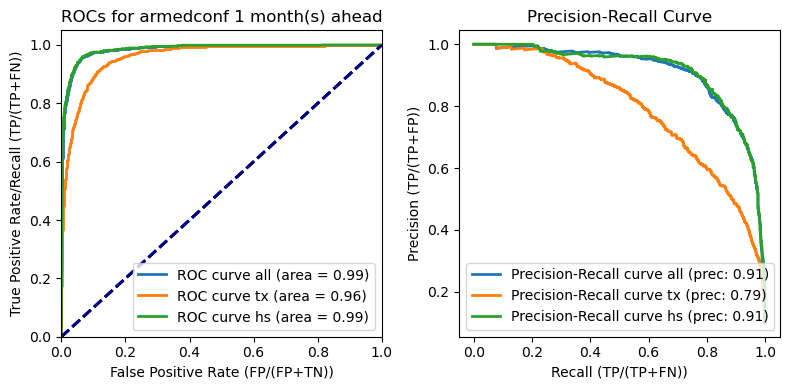

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
armedconf f_2
ROC: 0.982 Precision: 0.92
ROC: 0.955 Precision: 0.799
ROC: 0.982 Precision: 0.924


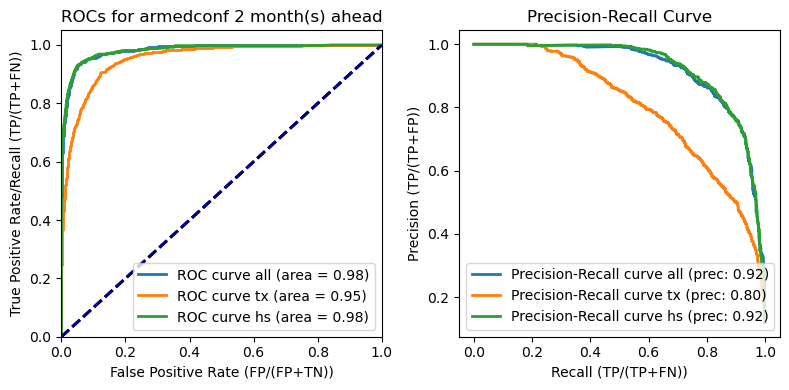

- - - - -- - - - - - - - - - - - - - - - - - - - - - 


In [156]:
for target in [target_clsf]:
    for sft in [1,2]: #,2]:
        print(target, f'f_{sft}') #, model)
        get_roc_pr(pred_all_clsf, sft, target, ['all', 'tx', 'hs'], start_month_year, True, True)
        print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')

In [147]:
def separation_plot(pdata, fname, alpha=1):
    '''
    Display observed events against predicted probabilities for binary classification problems
    Arguments
    ---------
        y : vector of observed class labels
        yhat : vector of predicted probabilities
        fname: file path to directory to save plot 
        alpha: float from 0 to 1, transparency of indicators of observed events
    '''

    pdata.columns = ['y', 'yhat']
    pdata = pdata.sort_values('yhat')
    pdata = pdata.reset_index(drop=True)

    events = pdata[pdata['y'] == 1]
    evals = events.index.values

    plt.figure(figsize=(20, 5))
    plt.ylabel('Predicted risk')
    ax = plt.gca()
    ax.set_xlim([1, (evals[-1] + 1)])
    ax.set_ylim([0, 1])
    
    rr = 0
    for i in evals:
        if rr == 0:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, label = 'Increases', zorder=2)
            rr = 1
        else:
            ax.axvline(x=i, linewidth=0.2, linestyle='-', color='k', alpha=alpha, zorder=1)
    
    ax.plot(pdata['yhat'], linestyle='--', color='red', lw = 4, label = 'Predicted increase', zorder=3)
    ax.set_xlabel('Rank of prediction')
    ax.legend(loc="upper left")
    #plt.savefig(fname)
    plt.show()
    plt.close() 

In [148]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

#monthsince as the key sufficient statistic - make sure you understand

def produce_stats(df, true_vals, pred_vals): #monthsince

    #drop any rows for which there are no predictions
    restricted=df.dropna(subset=[true_vals,f'{pred_vals}_all', f'{pred_vals}_hs', f'{pred_vals}_tx'])
    
    # IGNORED
    #only keep observations where there has been at least (0) months of peace
    #restricted=restricted[restricted["anyviolence_dp"]>=monthsince] #anyviolence_dp counts months of peace duration
    
    y_true=restricted[true_vals]

    # full model
    #y_scores=restricted[f'{pred_vals}_all']
    #print("observations:", len(y_scores))
    #print("full model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_all']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # history model
    #y_scores=restricted[f'{pred_vals}_hs']
    #print("history model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_hs']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # text model
    #y_scores=restricted[f'{pred_vals}_tx']
    #print("text model AUC:", roc_auc_score(y_true.astype('int'), restricted[f'{pred_vals}_tx']), "and av.precision:", average_precision_score(y_true.astype('int'), y_scores))

    # Print separation plots
    print("")

    print('Full model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_all']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')

    print('History model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_hs']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')

    print('Text model separation plot:')
    sep_data=restricted[[true_vals,f'{pred_vals}_tx']]
    #name=Path(spitout + "{}_separation_plot.pdf".format(model_fitted))
    separation_plot(sep_data, 'name')
    

In [138]:
pred_all_clsf

,month_year,isocode,armedconf,target_clsf_f1,target_clsf_f2,pred_armedconf_f1_all,pred_armedconf_f1_hs,pred_armedconf_f1_tx,pred_armedconf_f2_all,pred_armedconf_f2_hs,pred_armedconf_f2_tx
0,2018-01-01,AFG,True,1.0,1.0,0.995142,0.994840,0.963254,0.995673,0.996564,0.960798
1,2018-01-01,AGO,False,0.0,0.0,0.142580,0.245121,0.101268,0.238736,0.359429,0.130463
2,2018-01-01,ALB,False,0.0,0.0,0.016114,0.009213,0.191101,0.024153,0.016036,0.218202
3,2018-01-01,ARE,False,0.0,0.0,0.014535,0.026959,0.091182,0.026588,0.045413,0.122640
4,2018-01-01,ARG,False,0.0,0.0,0.012479,0.008730,0.146658,0.017840,0.015375,0.167677
...,...,...,...,...,...,...,...,...,...,...,...
9355,2021-12-01,XKX,False,0.0,0.0,0.018142,0.006846,0.220976,0.025809,0.011428,0.254796
9356,2021-12-01,YEM,True,1.0,1.0,0.991312,0.997137,0.880453,0.993880,0.997590,0.883558
9357,2021-12-01,ZAF,False,0.0,0.0,0.277189,0.257174,0.451693,0.349461,0.376909,0.475124
9358,2021-12-01,ZMB,False,0.0,0.0,0.010903,0.007069,0.260009,0.017402,0.012478,0.308534


-----------------------------------------------------------------------------------------
STATISTICS FOR armedconf as target and predicting 1 year(s) ahead

Full model separation plot:


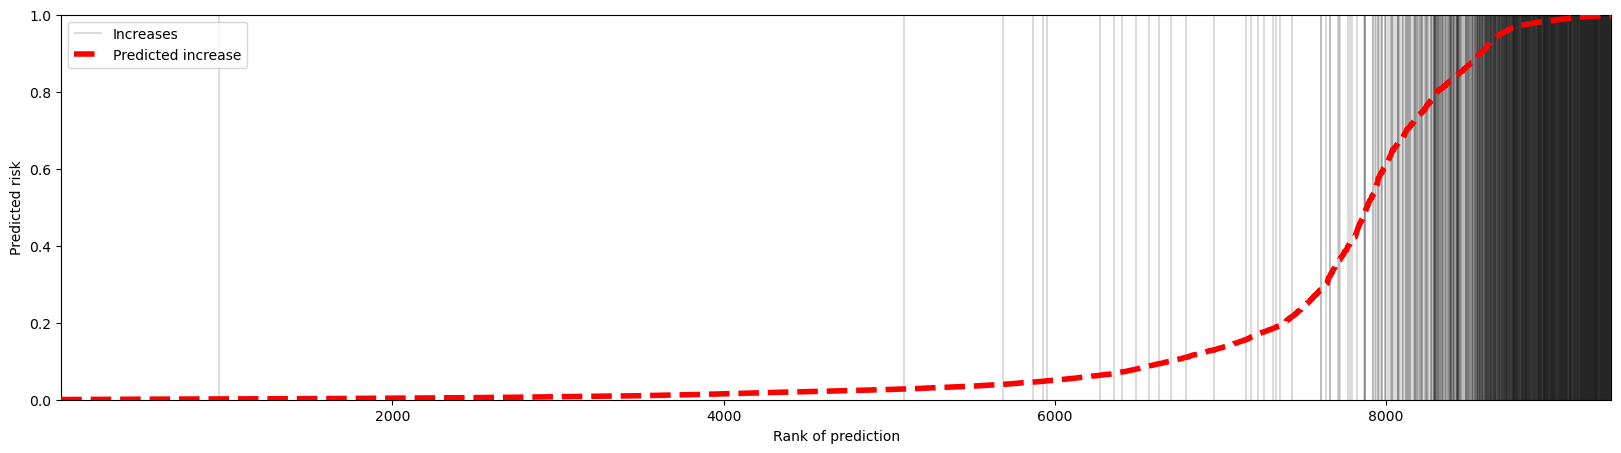

History model separation plot:


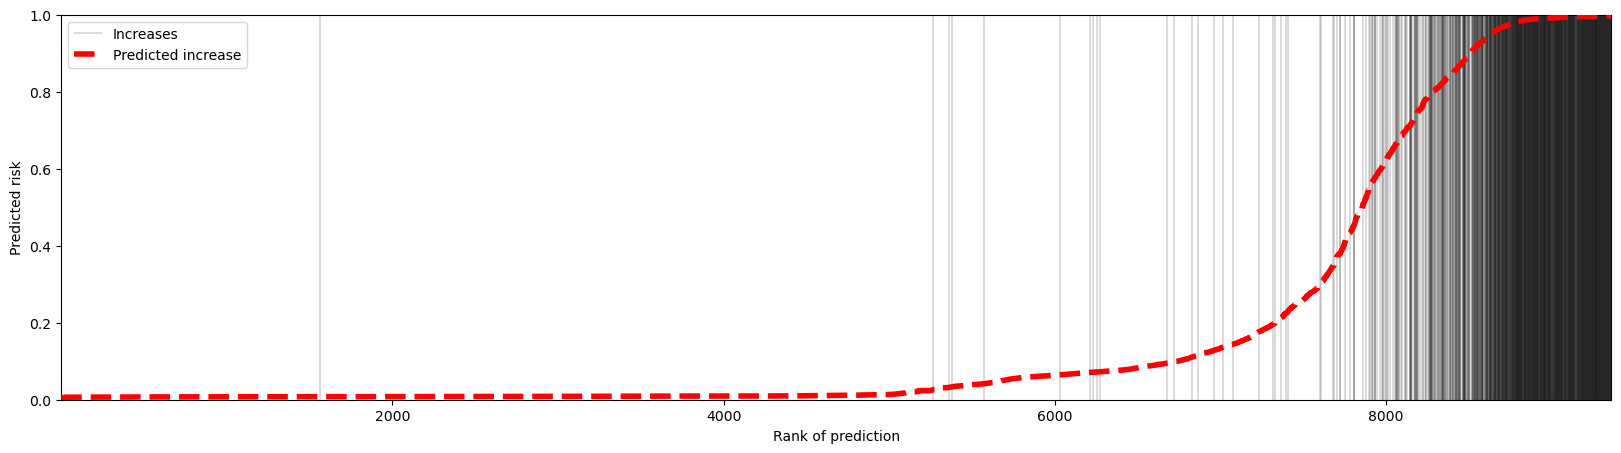

Text model separation plot:


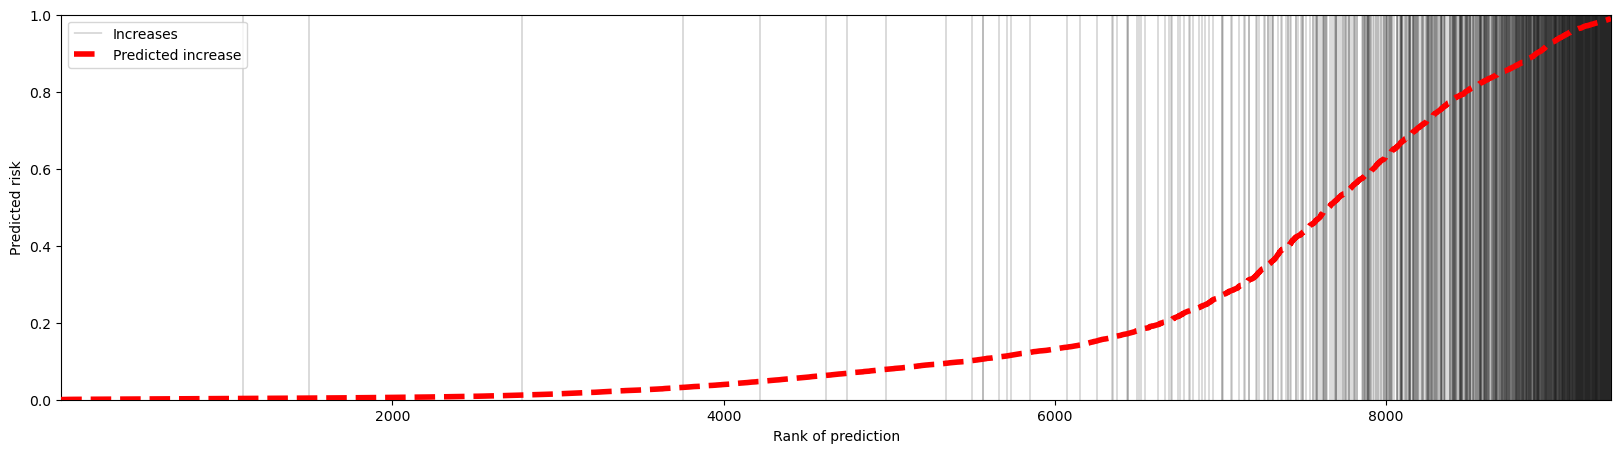

-----------------------------------------------------------------------------------------
STATISTICS FOR armedconf as target and predicting 2 year(s) ahead

Full model separation plot:


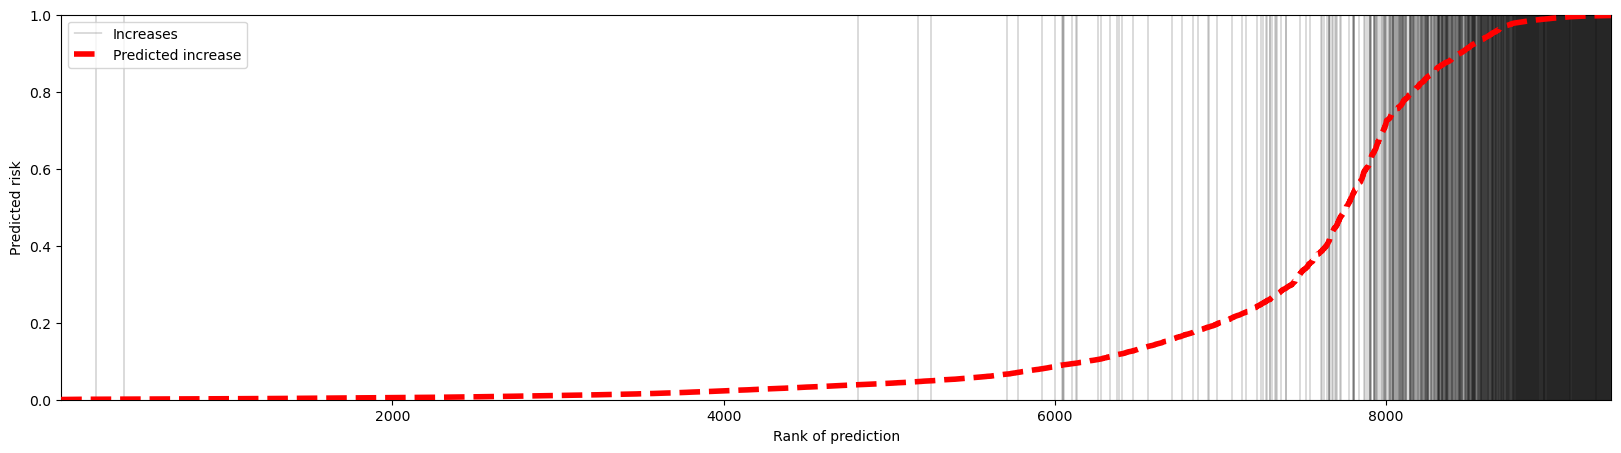

History model separation plot:


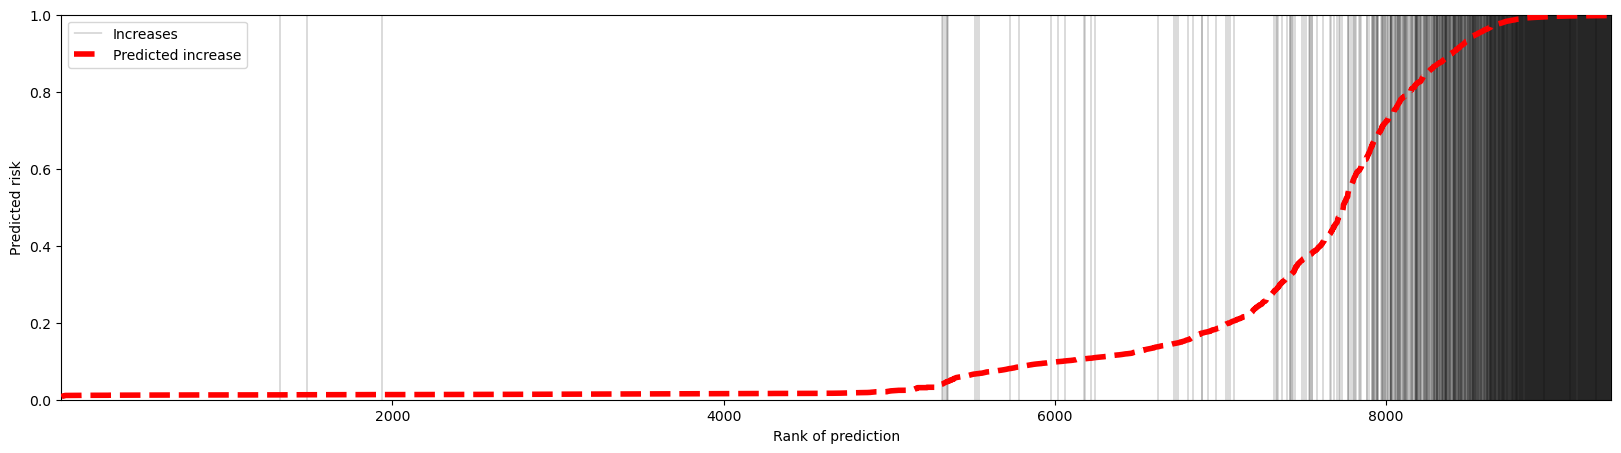

Text model separation plot:


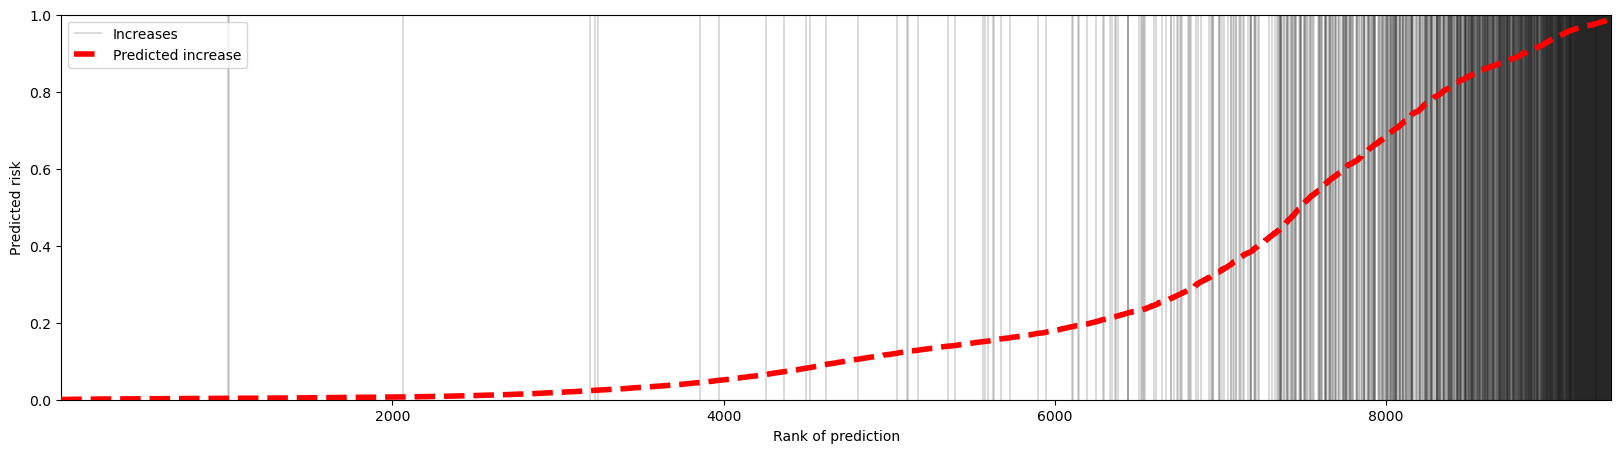

In [149]:
targets = ['armedconf']
forwards = [1,2]

for target in targets:
    for forward in forwards:
        print('-----------------------------------------------------------------------------------------')
        print(f'STATISTICS FOR {target} as target and predicting {forward} year(s) ahead')
        produce_stats(pred_all_clsf, f'target_clsf_f{forward}', f'pred_{target}_f{forward}')

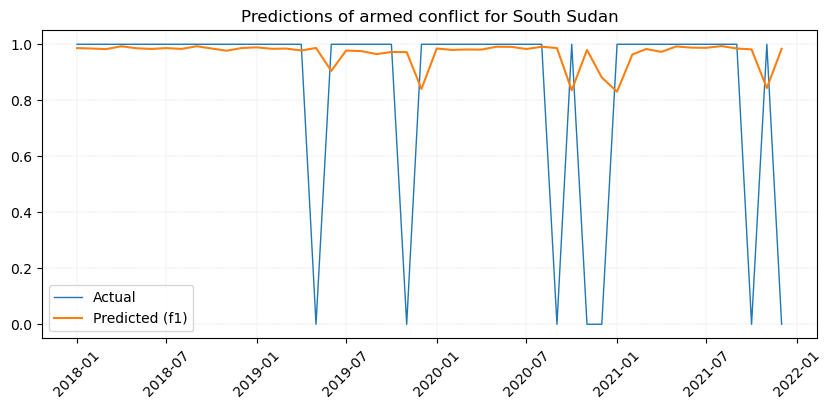

In [157]:
# pick country
country = 'SSD' #'SSD'
country_name = pc.countries.get(alpha_3=country)

country_clsf =  pred_all_clsf[pred_all_clsf.isocode == country]

plt.figure(figsize=(10,4))


plt.plot(country_clsf.month_year,country_clsf['target_clsf_f1'], linewidth=1)
plt.plot(country_clsf.month_year,country_clsf['pred_armedconf_f1_all'])

plt.title(f'Predictions of armed conflict for {country_name.name}')
plt.legend(['Actual', 'Predicted (f1)'])
plt.grid(color='grey', linestyle='--', linewidth=0.1)
plt.xticks(rotation=45)
plt.show()

### Metrics for XGboost Classifier

armedconf f_1
ROC: 0.984 Precision: 0.907
ROC: 0.972 Precision: 0.846
ROC: 0.984 Precision: 0.905


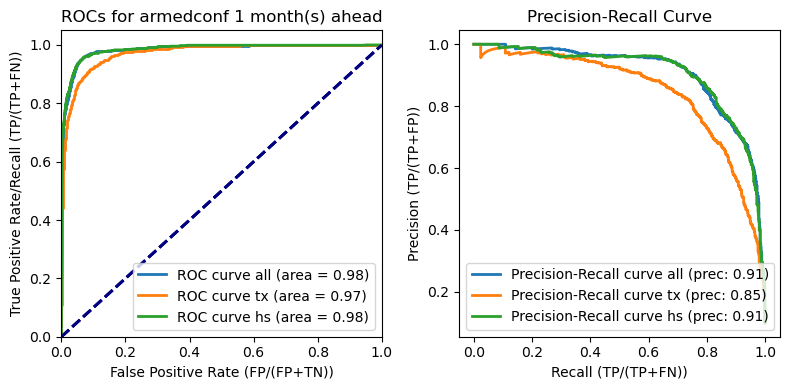

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
armedconf f_2
ROC: 0.981 Precision: 0.921
ROC: 0.965 Precision: 0.85
ROC: 0.98 Precision: 0.918


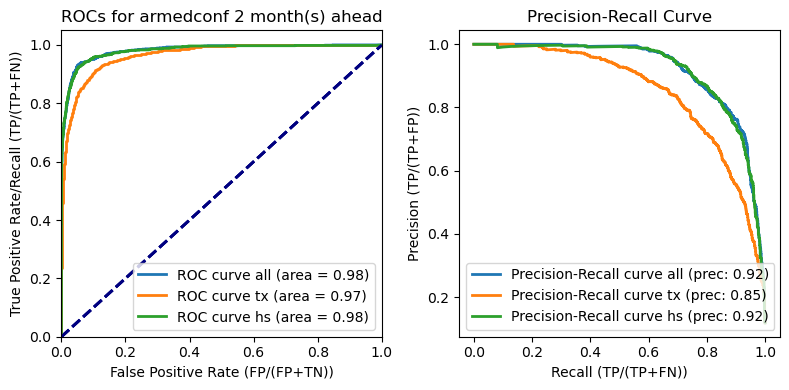

- - - - -- - - - - - - - - - - - - - - - - - - - - - 


In [18]:
for target in [target_clsf]:
    for sft in [1,2]: #,2]:
        print(target, f'f_{sft}') #, model)
        get_roc_pr(pred_all_xgb, sft, target, ['all', 'tx', 'hs'], start_month_year, True, True)
        print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')

### Metrics for tree-based regressor

In [159]:
target = target_regr
fwds = [1,2]#,2]
models = ['all', 'hs', 'tx']

start_date = start_month_year #start_date ##start_date = dt.datetime(2018, 1, 2)

errors = {}

for fwd in fwds:
    for model in models:
            
            y_trues, y_preds = get_tar_pred(pred_all_regr, fwd, model, start_date, target_regr, 'regr')
        
            errors[f'{model}_{fwd}'] = mean_squared_error(y_trues, y_preds)

print('All Root Mean Squared Errors:')
print(pd.Series(errors)) #.sort_values()

All Root Mean Squared Errors:
all_1    0.345163
hs_1     0.347220
tx_1     0.425364
all_2    0.642733
hs_2     0.648288
tx_2     0.550641
dtype: float64


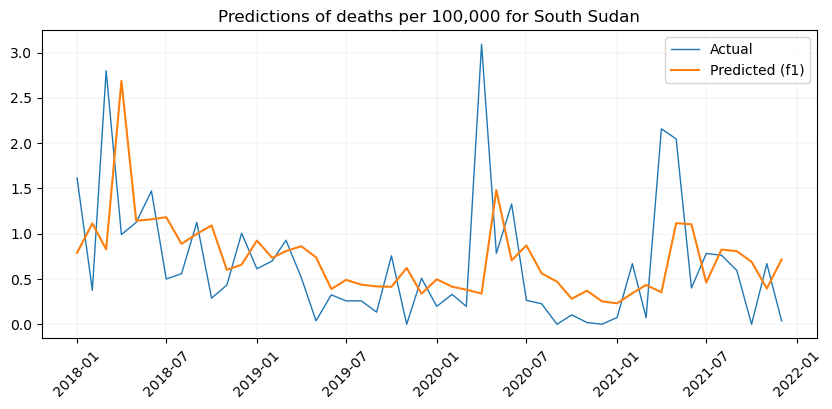

In [160]:
# pick country
country = 'SSD' # SSD
country_name = pc.countries.get(alpha_3=country)

country_regr =  pred_all_regr[pred_all_regr.isocode == country]

plt.figure(figsize=(10,4))


plt.plot(country_regr.month_year,country_regr['target_regr_f1'], linewidth=1)
plt.plot(country_regr.month_year,country_regr['pred_deaths_all_pc_f1_all'])

plt.title(f'Predictions of deaths per 100,000 for {country_name.name}')
plt.legend(['Actual', 'Predicted (f1)'])
plt.grid(color='grey', linestyle='--', linewidth=0.1)
plt.xticks(rotation=45)
plt.show()